In [1]:
import torch
from torch import onnx
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from model import MLP, Conv1DModel

def load_data(file_path: str) -> tuple:
    """데이터를 불러오는 함수
    Args:
        file_path (str): 데이터 파일의 경로
    Returns:
        X_train, y_train, X_test, y_test
    """
    data = pd.read_csv(file_path)
    # data = data.astype({'G(mg/dL)':'int'})
    X = data.drop('G(mg/dL)', axis=1).values
    y = data['G(mg/dL)'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return torch.tensor(X_train, dtype=torch.float32), \
        torch.tensor(y_train, dtype=torch.float32), \
        torch.tensor(X_test, dtype=torch.float32), \
        torch.tensor(y_test, dtype=torch.float32)

In [2]:
def train_model(model, train_loader, num_epochs, learning_rate, name:str):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc=f'Train {name}'):
        total_loss = 0
        total_batches = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            with torch.set_grad_enabled(True):
                y_hat = model(X)
                loss = criterion(y_hat.squeeze(), y)
                total_loss += loss.item()
                total_batches += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = total_loss / total_batches
        epoch_losses.append(epoch_loss)
    torch.save(model.state_dict(), f'property/{name}.pt')
    onnx.export(model, X.to(device), f'property/{name}.onnx')
    print("final loss : ", epoch_losses[num_epochs - 1])
    return epoch_losses

In [3]:

data_L13 = load_data('data/MixData_L13.csv')
data_L23 = load_data('data/MixData_L23.csv')
batch_size = 16

train_loader_L13 = DataLoader(TensorDataset(data_L13[0].unsqueeze(1), data_L13[1]), batch_size=batch_size, shuffle=True)
train_loader_L23 = DataLoader(TensorDataset(data_L23[0].unsqueeze(1), data_L23[1]), batch_size=batch_size, shuffle=True)

# mlp
model_mlp_L13 = MLP(7)
model_mlp_L23 = MLP(7)

# conv 1d
model_conv1d_L13 = Conv1DModel(1, 2)
model_conv1d_L23 = Conv1DModel(1, 2)

In [4]:
learning_rate = 0.001
num_epochs = 200

losses_mlp_L13 = train_model(model_mlp_L13, train_loader_L13, num_epochs, learning_rate, 'mlp_L13')
losses_mlp_L23 = train_model(model_mlp_L23, train_loader_L23, num_epochs, learning_rate, 'mlp_L23')

Train mlp_L13: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.95it/s]


final loss :  478.0408671061198


Train mlp_L23: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.36it/s]

final loss :  279.8779037475586


In [5]:
losses_conv1d_L13 = train_model(model_conv1d_L13, train_loader_L13, num_epochs, learning_rate, 'conv1d_L12')
losses_conv1d_L23 = train_model(model_conv1d_L23, train_loader_L23, num_epochs, learning_rate, 'conv1d_L21')

Train conv1d_L12: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.96it/s]
C:\Work\CGM\ETRI_CGM_Analysis_ModelDev\JaeseongArea\model\_1d_conv_net.py:28: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = functional.avg_pool1d(x, kernel_size=int(x.size(dim=2)))


final loss :  4970.910026041666


Train conv1d_L21: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.28it/s]

final loss :  5774.464103190104


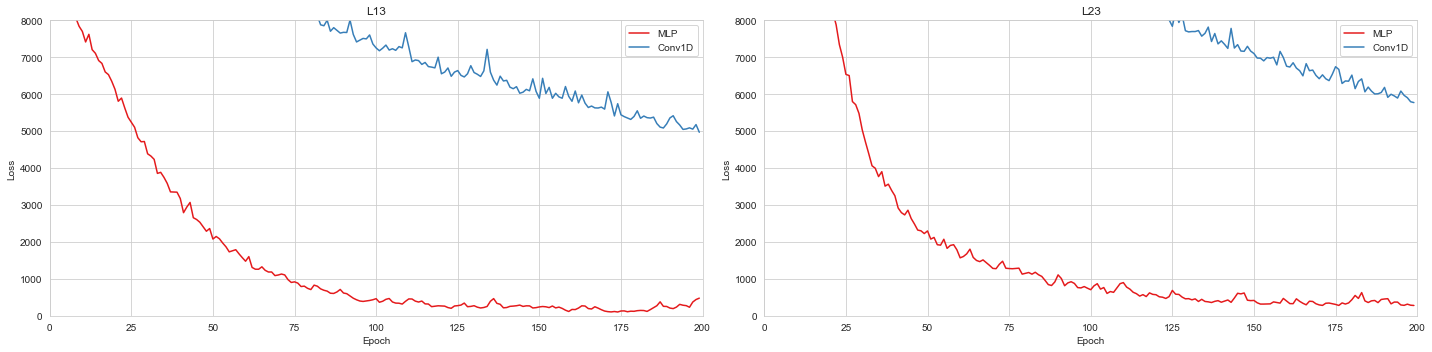

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(losses_mlp_L13, label='MLP')
ax1.plot(losses_conv1d_L13, label='Conv1D')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('L13')
ax1.set_ylim(0, 8E3)
ax1.set_xlim(0, num_epochs)

ax2.plot(losses_mlp_L23, label='MLP')
ax2.plot(losses_conv1d_L23, label='Conv1D')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('L23')
ax2.set_ylim(0, 8E3)
ax2.set_xlim(0, num_epochs)

plt.tight_layout()
plt.show()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from sklearn.metrics import mean_squared_error, r2_score


def model_infer(model, loder) -> tuple:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in loder:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            y_pred.append(y_hat.cpu().numpy())
            y_true.append(y.cpu().numpy())
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2    

In [10]:
def append_graph(ax, y, y_pred, title):
    ax.scatter(y, y_pred, s=1, label=title)# 'MLP_L23'
    ax.plot([0, 1000], [0, 1000], 'k--')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_title(f'{title} (RMS: {rms:.2f}, R2: {r2:.2f})')

#### 데이터 조합(1 + 3, 2 + 3)에 따른 MLP, Conv1d의 R1 Score

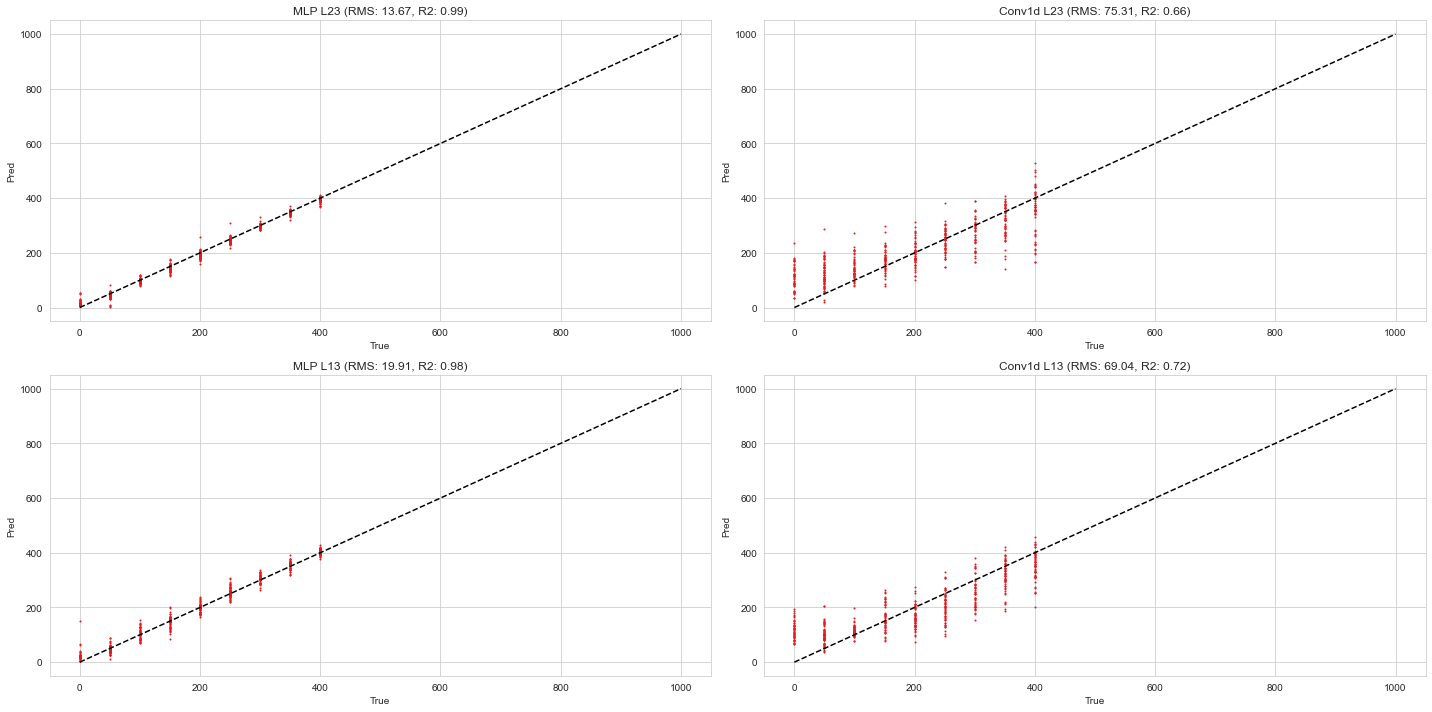

In [14]:
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 10))
y_pred, y_true, rms, r2 = model_infer(model_mlp_L23, train_loader_L23)
append_graph(ax1[0], y_true, y_pred, 'MLP L23')

y_pred, y_true, rms, r2 = model_infer(model_conv1d_L23, train_loader_L23)
append_graph(ax1[1], y_true, y_pred, 'Conv1d L23')

y_pred, y_true, rms, r2 = model_infer(model_mlp_L13, train_loader_L13)
append_graph(ax2[0], y_true, y_pred, 'MLP L13')


y_pred, y_true, rms, r2 = model_infer(model_conv1d_L13, train_loader_L13)
append_graph(ax2[1], y_true, y_pred, 'Conv1d L13')

plt.tight_layout()
plt.show()